<a href="https://colab.research.google.com/github/Wapiti08/InfPrd/blob/main/link_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install stellargraph==1.2.1
!pip3 install networkx==2.5

     |████████████████████████████████| 435 kB 11.6 MB/s 
     |████████████████████████████████| 462 kB 34.3 MB/s 
     |████████████████████████████████| 1.6 MB 12.9 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# split the data and create training and test reduced subgraphs
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph
import networkx as nx
from sklearn.model_selection import train_test_split

In [4]:
# G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)
G = nx.read_edgelist("107.edges", create_using=nx.Graph(), nodetype=int)
# create splitter instance for subgraphs
edgeSplitter = EdgeSplitter(G)
# split data for test
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)
# g and g_master
edgeSplitter = EdgeSplitter(graph_test, G)
# split data for train
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)


** Sampled 2674 positive and 2674 negative edges. **
** Sampled 2407 positive and 2407 negative edges. **


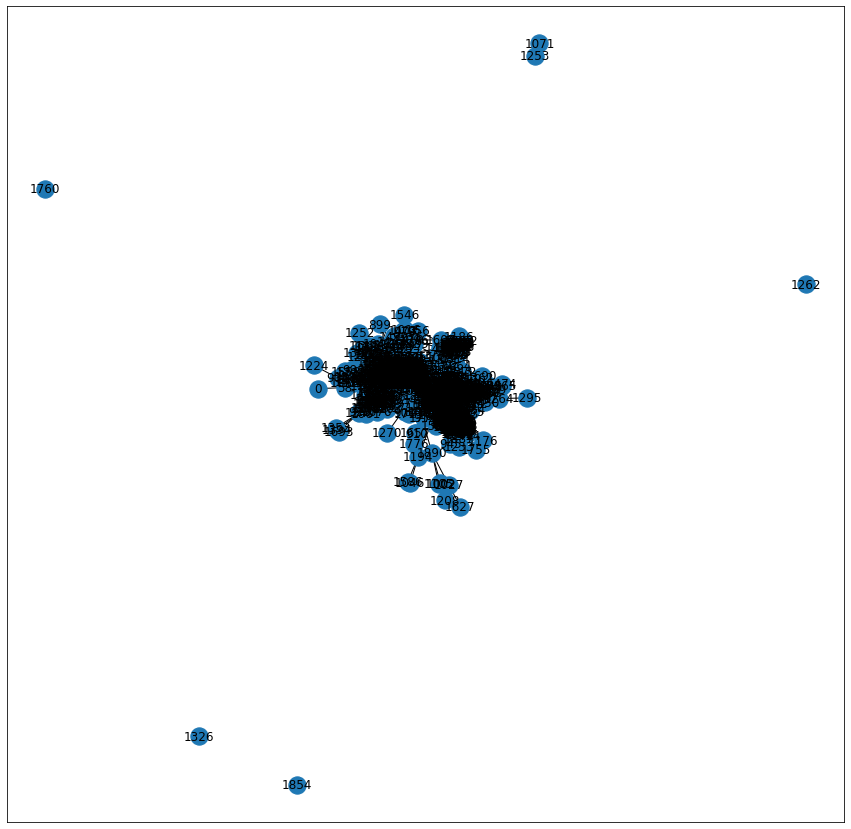

In [5]:
# explore the subgraphs a bit
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
nx.draw_networkx(graph_train)
plt.show()

### Node2Vec without supervision

In [7]:
# avoid the error about:
'''
    __init__() got an unexpected keyword argument 'size' in node2vec
'''
!pip3 install node2vec==0.3.3
!pip3 install -I --user gensim==4.0.1

  Created wheel for node2vec: filename=node2vec-0.3.3-py3-none-any.whl size=5673 sha256=39c53b4ef7c1b2355f6db137ff94c9da20421c057c7efcaff6461da4e160f201
  Stored in directory: /root/.cache/pip/wheels/da/ba/7d/e3e173c4133d8b8c498981bdd8b115e4bd5dcf6c314e513fa6
Successfully built node2vec
     |████████████████████████████████| 23.9 MB 2.0 MB/s 
     |████████████████████████████████| 15.7 MB 7.4 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatibl

In [11]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

# generate node embedding for graph
node_vec = Node2Vec(graph_train)
node_model = node_vec.fit()
# generating an embedding for each pair of embedded nodes
edges_embs = HadamardEmbedder(keyed_vectors=node_model.wv)
# traverse to get all the node embeddings
train_embs = [edges_embs[str(x[0]), str(x[1])] for x in samples_train]
test_embs = [edges_embs[str(x[0]), str(x[1])] for x in samples_test]


# import the class
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(n_estimators=10)
rf.fit(train_embs, labels_train)

# predict
y_pred = rf.predict(test_embs)
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred))


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Precision: 0.9033816425120773
Recall: 0.9091249065071054
F1-Score: 0.9062441752096925


In [ ]:
# explore the subgraphs a bit
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
nx.draw_networkx(graph_train)
plt.show()

In [ ]:
G.nodes()[0]

### GraphSAGE


In [ ]:
# the network requires features, have to make fake features instead
import numpy as np

eye_array = np.eye(graph_train.number_of_nodes())
fake_train_features = [ for node in G.]

### Hand-crafted features